In [17]:
import anndata as ad
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
from random import shuffle
from sklearn.metrics.pairwise import pairwise_kernels
from SEMITONES.cell_selection import from_knn_dist
from SEMITONES.support_funcs import sig_dictionary
from SEMITONES.support_funcs import sig_bool
from SEMITONES.enrichment_scoring import sig_interval
from scipy import stats
from itertools import compress

In [2]:
adata = ad.read_h5ad("../processed/Luecken_multiome_BMMC-r_adata.h5ad")

In [3]:
wnn_umap2= np.genfromtxt('../processed/Luecken_wnn_umap.csv', delimiter=',')
wnn_umap25= np.genfromtxt('../processed/Luecken_wnn_umap25.csv', delimiter=',')

In [4]:
iATAC = np.where(adata.var['feature_types']=='ATAC')[0]
iGEX = np.where(adata.var['feature_types']=='GEX')[0]

In [6]:
# determine gamma, select the gamma value that the most cell types are covered by at least one reference cell
def n_rcell(g):
    
    S = pairwise_kernels(wnn_umap25, metric='rbf',gamma=g)
    median = np.median(S, axis=0)
    start = int(np.argmin(median))

    dd_rcells = from_knn_dist(X=wnn_umap25,
                             n_ret=100,
                             start=start,
                             metric='rbf',
                             metric_params={"gamma": g})
    r_cell_type=adata.obs['cell_type'][dd_rcells]
    res = r_cell_type.unique().shape[0]
    return res

nl = []
gl = []
# because this step is time consuming, we took a smaller range of gamma as example
for g in np.arange(0.5,0.7,0.01):
    nl.append(n_rcell(g))
    gl.append(g)

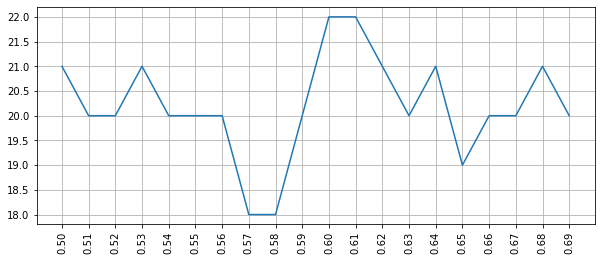

In [19]:
plt.figure(figsize=(10,4))
plt.plot(gl,nl)
plt.xticks(np.arange(0.5,0.7,0.01), rotation=90)
plt.grid()
plt.show()

In [9]:
# check the selected reference cells
g=0.6

S = pairwise_kernels(wnn_umap25, metric='rbf',gamma=g)
median = np.median(S, axis=0)
start = int(np.argmin(median))

dd_rcells = from_knn_dist(X=wnn_umap25,
                         n_ret=100,
                         start=start,
                         metric='rbf',
                         metric_params={"gamma": g})

In [10]:
r_cell_type=adata.obs['cell_type'][dd_rcells]
r_cell_type.value_counts()

CD14+ Mono             17
CD8+ T                 15
NK                     10
CD4+ T activated        9
Naive CD20+ B           7
Erythroblast            6
CD4+ T naive            5
Proerythroblast         5
B1 B                    4
Lymph prog              3
Transitional B          3
Normoblast              3
pDC                     2
HSC                     2
G/M prog                2
MK/E prog               1
ID2-hi myeloid prog     1
Plasma cell             1
CD16+ Mono              1
CD8+ T naive            1
cDC2                    1
ILC                     1
Name: cell_type, dtype: int64

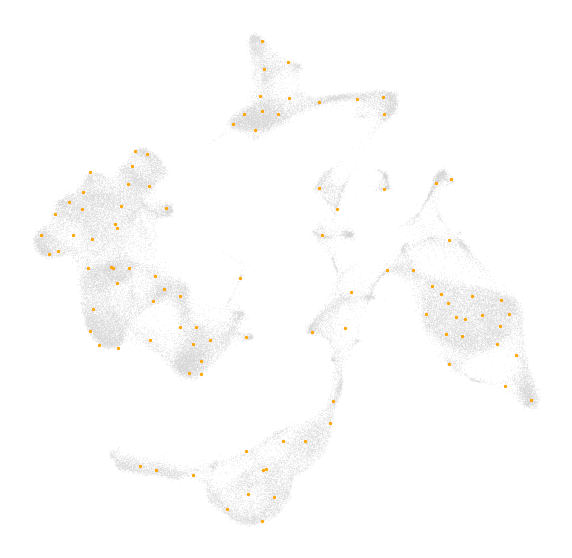

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(wnn_umap2[:,0],wnn_umap2[:,1],s=0.01,c='lightgrey')
plt.scatter(wnn_umap2[dd_rcells, 0], wnn_umap2[dd_rcells, 1], s=5, c='orange')
plt.axis('off')
plt.show()

Run Luecken_scores.py to calculate SEMITONES enrichment scores and permutation scores.

In [12]:
ATAC_es = pd.read_hdf('../processed/Luecken_ATAC_escore.h5','escores')
ATAC_ps = pd.read_hdf('../processed/Luecken_ATAC_pscore.h5','pscores')

In [13]:
# determine the significantly enriched features
ATAC_interval = sig_interval(ATAC_ps, n_sds=10)
ATAC_sigdict = sig_dictionary(ATAC_es, ATAC_interval)
ATAC_sigbool = sig_bool(ATAC_es, ATAC_interval)

In [14]:
# load Homer annotation
ann = pd.read_csv('../processed/Luecken_ATAC_ann_hg38.txt', sep='\t', index_col=0)
ann.sort_index(inplace=True)
ann.reset_index(drop=True, inplace=True)

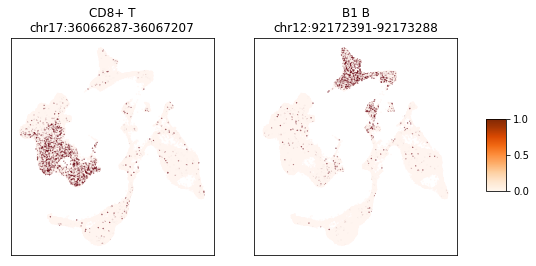

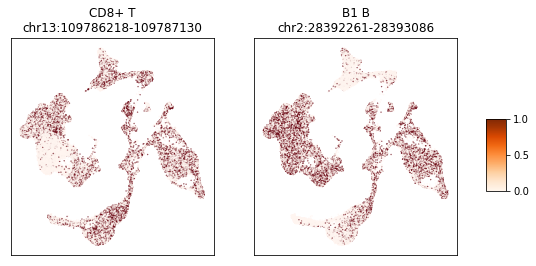

In [18]:
# examples of selectively accessible regions and selectively inaccessible regions identified by SEMITONES
atac_sparse = adata.X[:,adata.var['feature_types']=='ATAC']
names = ann['Chr']+':'+ann['Start'].astype(str)+'-'+ann['End'].astype(str)

def top_one_plots(rcells_list, acc='acc'):
    fig, axs = plt.subplots(1,len(rcells_list), figsize=(4*len(rcells_list),4))
    for ax,rcell in zip(axs, rcells_list):
        
        if acc=='acc':
            # selectively acc
            index = ATAC_es[rcell].rank(ascending=False).sort_values().index[0]
        else:
            # selectively inacc
            index = ATAC_es[rcell].rank(ascending=True).sort_values().index[0]

        ct = adata.obs['cell_type'][rcell]
        ft = names[index]

        colors = atac_sparse[:,index].todense().tolist()
        z = [x==0 for x in colors]
        nz = [x!=0 for x in colors]

        ax.scatter(wnn_umap2[z,0],wnn_umap2[z,1],c=list(compress(colors,z)),s=0.1)
        ax.scatter(wnn_umap2[nz,0],wnn_umap2[nz,1],c=list(compress(colors,nz)),cmap='Reds',s=0.1)
        #ax.scatter(wnn_umap2[:,0], wnn_umap2[:,1], c=colors, cmap='Oranges', s=0.01)
        ax.set_title('{}\n{}'.format(ct, ft))
        ax.set_xticks([])
        ax.set_yticks([])
    sm =  ScalarMappable(norm=plt.Normalize(0, 1), cmap='Oranges')
    sm.set_array([])
    # [left, bottom, width, height]
    cax = plt.axes([0.95, 0.35, 0.035, 0.25])
    cbar = fig.colorbar(sm, ax=axs, cax=cax)
    fig.savefig('../figures/SEMITONES/Luecken_{}_umap.png'.format(acc), bbox_inches='tight')
    plt.show()

#rcell = escores.columns[2]
top_one_plots([ATAC_es.columns[5], ATAC_es.columns[9]], acc='acc')
top_one_plots([ATAC_es.columns[5], ATAC_es.columns[9]], acc='inacc')